In [ ]:
!apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
!pip install pymdptoolbox
!pip install latex

In [47]:
# import libraries
import random
import matplotlib.pyplot as plt

# Selfish Mining (SM1)

In [48]:
class SM1:
    # p -> adversary hashrate
    # gamma -> communication capability of the adversary
    def __init__(self, p, gamma, n_iter, show_log=False):
        random.seed(None)
        if p < 0 or p > 0.5:
          raise ValueError('adversary hashrate must be in between 0 and 0.5')
        self.p = p
        if gamma < 0 or gamma > 1:
          raise ValueError('gamma must be in between 0 and 1')
        self.gamma = gamma
        self.__show_log = show_log
        # honest chain length
        self.length_h = 0
        # adversary chain length
        self.length_a = 0
        # chain length difference
        self.delta = 0

        self.n_block_a = 0
        self.n_block_h = 0

        self.r_a = 0
        self.r_h = 0

        self.n_blocks = 0
        self.n_stale_blocks = 0

        self.n_iter = n_iter

    def __repr__(self):
        return "(p: %d, gamma: %d)" % (self.p, self.gamma)

    def simulate(self):
        self.log('starting simulation')
        iter_count = self.n_iter

        for i in range(iter_count):
            self.log("new block found")
            random_number = random.random()

            # calculate delta
            self.delta = self.length_a - self.length_h
            # self.log('delta is : {}'.format(self.delta))

            # Mining Process
            if random_number < self.p:
                self.mine_s()
            else:
                self.mine_h()

        self.update_state()

    def mine_s(self):
        self.log('starting selfish mining')

        self.length_a += 1
        # self.delta = self.length_a - self.length_h
        if self.delta == 0 and self.length_a == 2:
            self.n_block_a += 2
            self.length_a = 0
            self.length_h = 0

    def mine_h(self):
        self.log('starting honest mining!')

        self.length_h += 1
        # self.delta = self.length_a - self.length_h
        if self.delta == 0 and self.length_a == 0:
            # print('2')
            self.n_block_h += 1
            self.length_a = 0
            self.length_h = 0

        elif self.delta == 0 and self.length_a == 1:
            gamma_random = random.random()

            if gamma_random < self.gamma:
                self.n_block_a += 1
                self.n_block_h += 1
                self.length_a = 0
                self.length_h = 0
            else:
                self.n_block_h += 2
                self.length_a = 0
                self.length_h = 0

        elif self.delta == 2:
            self.n_block_a += self.length_a
            self.length_h = 0
            self.length_a = 0
        # delta > 2 or delta = 1
        else:
          return

    def update_state(self):
        self.n_blocks = self.n_block_h + \
            self.n_block_a
        self.n_stale_blocks = self.n_iter - self.n_blocks

        self.r_h = float(
            self.n_block_h / self.n_blocks)
        self.r_a = float(
            self.n_block_a / self.n_blocks)

    def get_stats(self):

        print('-------------------------------------------')

        print(self.__repr__())

        print('honest miners win block is : {}'.format(
            self.n_block_h))
        print('selfish miners win block is : {}'.format(
            self.n_block_a))

        print('total mined block is : {}'.format(self.n_blocks))
        print('total stale block is : {}'.format(self.n_stale_blocks))

        print('honest miner revenue is : {}'.format(
            self.r_h))
        print('selfish miner revenue is : {}'.format(
            self.r_a))

        print('honest miner expected reward is : {}'.format(
            (1 - self.p) * self.n_iter * 100 / self.n_iter))
        print('selfish miner expected reward is : {}'.format(
            (self.p) * self.n_iter * 100 / self.n_iter))

        print('--------------------------------------------')

    def log(self, log_message):
        if self.__show_log:
            print(log_message)

    def reset(self):
        random.seed(None)

        self.length_h = 0
        self.length_a = 0
        self.delta = 0

        self.n_block_a = 0
        self.n_block_h = 0

        self.r_a = 0
        self.r_h = 0

        self.n_blocks = 0
        self.n_stale_blocks = 0

        self.n_iter = 0

In [158]:
from scipy.signal import savgol_filter

def plot_revenues(ps, gamma, stale, cutoff, cost, lam, eps=0.001, cached=False,n_iter=10000):
  hm_revenue = []
  sm_revenue = []
  rev = np.zeros(ps.shape)
  u_bounds = []
  c = ['red', 'blue', 'green', 'black']
  if cached:
    rev = np.load('mdp.npy')

  for idx, p in enumerate(ps):
    print('Hashrate ', p)
    # selfish mining (sm1)
    sm = SM1(p, gamma, n_iter)
    sm.simulate()
    sm_revenue.append(sm.r_a)

    # optimal strategy
    if not(cached):
      mdp, states, rho = optimal_strategy(p, stale, gamma, cutoff, cost, lam=lam, eps=eps)
      rev[idx] = rho

    # honest mining
    hm_revenue.append(p)

    # upper bound
    u_bounds.append(p/(1-p))

  # save mdp results
  np.save("mdp.npy", rev)

  # plot optimal rho
  plt.plot(ps, rev, 'kx', label='eps-OPT policy')

  # plot selfish
  sm_revenue_hat = savgol_filter(sm_revenue, len(ps), 3)
  plt.plot(ps, sm_revenue_hat, color='blue', label='SM1')

  # plot honest
  plt.plot(ps, hm_revenue, color='red', linestyle='dashed', label='Honest mining')

  # plot upper bound
  plt.plot(ps, u_bounds, 'g', label='Upper Bound')

  plt.xlabel(r"Adversary hashrate $\alpha$", fontsize=12)
  plt.ylabel("Relative revenue", fontsize=12)
  plt.xticks(np.arange(0, 0.5, 0.05), fontsize=12)
  plt.yticks(fontsize=12)
  plt.legend(loc=2, prop={'size': 12})

Hashrate  0.025
Hashrate  0.05
Hashrate  0.07500000000000001
Hashrate  0.1
Hashrate  0.125
Hashrate  0.15
Hashrate  0.17500000000000002
Hashrate  0.2
Hashrate  0.225
Hashrate  0.25
Hashrate  0.275
Hashrate  0.30000000000000004
Hashrate  0.32500000000000007
Hashrate  0.35000000000000003
Hashrate  0.37500000000000006
Hashrate  0.4
Hashrate  0.42500000000000004
Hashrate  0.45000000000000007
Hashrate  0.47500000000000003


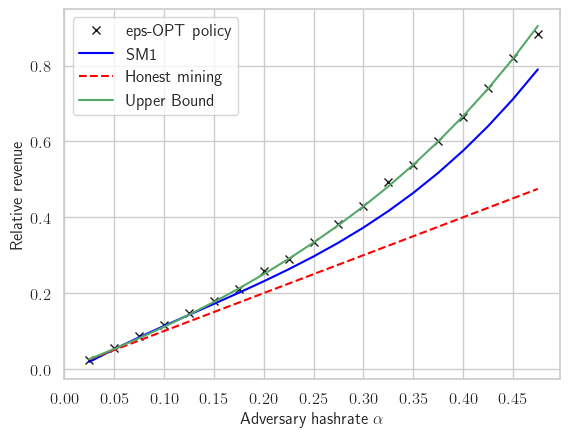

In [160]:
# ps = [x / 100 for x in range(0, 51)]
ps = np.arange(0.025, 0.5, 0.025)
plot_revenues(ps, gamma=1, stale=0.01, cutoff=20, cost=0, lam=0, eps=0.1)

In [144]:
a = np.array([1,2,3])
np.save('test3.npy', a)
d = np.load('test3.npy')
print(d)

[1 2 3]


# Optimal mining (V2)

In [109]:
import mdptoolbox
import random
import numpy as np
import networkx as nx
import matplotlib
matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
import queue as Queue
from matplotlib.colors import LogNorm
import seaborn
# seaborn.set(font_scale=2.3)
seaborn.set_style("whitegrid")
import sys

In [56]:
class State:
    def __init__(self, l_a, l_h, b_e, match="relevant"):
        self.length_a = l_a
        self.length_h = l_h
        self.blocks_e = b_e
        self.match = match

    def __hash__(self):
        return hash((self.length_a, self.length_h, self.blocks_e, self.match))

    def __eq__(self, other):
        try:
            return (self.length_a, self.length_h, self.blocks_e, self.match) == (other.length_a, other.length_h, other.blocks_e, other.match)
        except:
            return False

    def __ne__(self, other):
        return not(self == other)

    def __repr__(self):
        return "(%d, %d, %d, %s)" % (self.length_a, self.length_h, self.blocks_e, self.match)

In [57]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def reward(a, h, rho):
    return (1-rho)*a - rho*h

In [76]:
def optimal_strategy_mdp(p, stale, gamma, cutoff, cost, rho, lam=0):
    """
    p: attacker hashrate as fraction of total hashrate
    stale_rate: rate of stale blocks in honest network
    double_spend_value: the value that the attacker gains from a successful double spend, 1 = block reward
    gamma: fraction of honest nodes that a block from the attacker reaches before a block from the honest network (when matching)
    gamma is not relevant for ethereum, as ethereum uses tie breaking (i.e. gamma=0.5, but the attacker can always match if the chain is long enough and he does not need to have a block prepared) -> simpler state space
    cutoff: maximum length of either chain (needed for finite MDP)
    m_cost: cost of mining (per state transition)
    lam: hashrate of eclipsed miner

    implicitly:
        q = (1 - p - lam) hashrate of honest network
        q*(1-stale) probability that the honest chain grows (in each step)
        q*stale probability that state stays the same
    """
    states = {}
    states_inverted = {}
    q = 1-p-lam
    a_cost = cost*p
    h_cost = cost*(1-p)

    match_cases = ["irrelevant", "relevant", "active"]

    # construct states
    states_counter = 0
    for l_a in range(cutoff + 1):
        for l_h in range(cutoff + 1):
            for b_e in range(l_a+1):
                if lam == 0 and b_e > 0:
                    continue
                for match in match_cases:
                    state = State(l_a, l_h, b_e, match)
                    states[states_counter] = state
                    states_inverted[state] = states_counter
                    states_counter += 1

    # build transition matrices
    P_adopt    = np.zeros(shape=(states_counter, states_counter))
    P_override = np.zeros(shape=(states_counter, states_counter))
    P_match    = np.zeros(shape=(states_counter, states_counter))
    P_wait     = np.zeros(shape=(states_counter, states_counter))

    # build reward matrices
    R_adopt    = np.zeros(shape=(states_counter, states_counter))
    R_override = np.zeros(shape=(states_counter, states_counter))
    R_match    = np.zeros(shape=(states_counter, states_counter))
    R_wait     = np.zeros(shape=(states_counter, states_counter))

    for state_idx, state in states.items():
        l_a = state.length_a
        l_h = state.length_h
        b_e = state.blocks_e
        match = state.match

        # adopt
        # attacker mines next block
        P_adopt[state_idx, states_inverted[State(1, 0, 0, "irrelevant")]] = p
        R_adopt[state_idx, states_inverted[State(1, 0, 0, "irrelevant")]] = reward(-a_cost, l_h -h_cost, rho)
        # eclipsed node mines next block
        if lam != 0:
            P_adopt[state_idx, states_inverted[State(1, 0, 1, "irrelevant")]] = lam
            R_adopt[state_idx, states_inverted[State(1, 0, 1, "irrelevant")]] = reward(-a_cost, l_h -h_cost, rho)
        # network mines next block
        P_adopt[state_idx, states_inverted[State(0, 1, 0, "relevant")]] = q*(1-stale)
        R_adopt[state_idx, states_inverted[State(0, 1, 0, "relevant")]] = reward(-a_cost, l_h -h_cost, rho)
        # network mines stale block
        P_adopt[state_idx, states_inverted[State(0, 0, 0, "irrelevant")]] = q*stale
        R_adopt[state_idx, states_inverted[State(0, 0, 0, "irrelevant")]] = reward(-a_cost, l_h -h_cost, rho)


        # override
        if l_a > l_h:
            payout = (l_h+1)*(l_a - b_e)//l_a
            new_b_e = b_e - (l_h+1 - payout)
            # attacker mines next block
            P_override[state_idx, states_inverted[State(l_a - l_h, 0, new_b_e, "irrelevant")]] = p
            R_override[state_idx, states_inverted[State(l_a - l_h, 0, new_b_e,"irrelevant")]] = reward(payout - a_cost, b_e - new_b_e -h_cost, rho)
            # eclipsed node mines next block
            if lam != 0:
                P_override[state_idx, states_inverted[State(l_a - l_h, 0,new_b_e + 1, "irrelevant")]] = lam
                R_override[state_idx, states_inverted[State(l_a - l_h, 0,new_b_e + 1,"irrelevant")]] = reward(payout - a_cost, b_e - new_b_e -h_cost, rho)
            # network mines next block
            P_override[state_idx, states_inverted[State(l_a-l_h-1, 1, new_b_e, "relevant")]] = q*(1 - stale)
            R_override[state_idx, states_inverted[State(l_a-l_h-1, 1, new_b_e, "relevant")]] = reward(payout - a_cost, b_e - new_b_e -h_cost, rho)
            # network mines stale block
            P_override[state_idx, states_inverted[State(l_a-l_h-1, 0, new_b_e, "irrelevant")]] = q*stale
            R_override[state_idx, states_inverted[State(l_a-l_h-1, 0, new_b_e, "irrelevant")]] = reward(payout - a_cost, b_e - new_b_e -h_cost, rho)
        else:
            # needed for stochastic matrix, not sure if there is a better way to do this
            P_override[state_idx, state_idx] = 1
            R_override[state_idx, state_idx] = -100

        # only allow adopt, override after cutoff
        if l_a == cutoff or l_h == cutoff:
            # needed for stochastic matrix, not sure if there is a better way to do this
            P_match[state_idx, state_idx] = 1
            R_match[state_idx, state_idx] = -100
            P_wait[state_idx, state_idx] = 1
            R_wait[state_idx, state_idx] = -100
            continue

        # match
        if match == "relevant" and l_a >= l_h and l_h > 0:
            payout = (l_h)*(l_a - b_e)//l_a
            new_b_e = b_e - (l_h - payout)
            # attacker mines next block
            P_match[state_idx, states_inverted[State(l_a + 1, l_h, b_e, "active")]] = p
            R_match[state_idx, states_inverted[State(l_a + 1, l_h, b_e, "active")]] = reward(- a_cost, -h_cost, rho)
            # eclipsed node mines next block
            if lam != 0:
                P_match[state_idx, states_inverted[State(l_a + 1, l_h,b_e+1, "active")]] = lam
                R_match[state_idx, states_inverted[State(l_a + 1, l_h,b_e+1, "active")]] = reward(-a_cost, -h_cost, rho)
            # network mines next block on chain released by attacker
            P_match[state_idx, states_inverted[State(l_a - l_h, 1, new_b_e, "relevant")]] = gamma*q*(1 - stale)
            R_match[state_idx, states_inverted[State(l_a - l_h, 1, new_b_e, "relevant")]] = reward(payout - a_cost, b_e - new_b_e -h_cost, rho)
            # network mines next block on honest chain
            P_match[state_idx, states_inverted[State(l_a, l_h +  1, b_e, "relevant")]] = (1-gamma)*q*(1 - stale)
            R_match[state_idx, states_inverted[State(l_a, l_h +  1, b_e, "relevant")]] = reward(-a_cost, -h_cost, rho)
            # network mines stale block
            P_match[state_idx, states_inverted[State(l_a, l_h, b_e, "active")]] = q*stale
            R_match[state_idx, states_inverted[State(l_a, l_h, b_e, "active")]] = reward(-a_cost, -h_cost, rho)
        else:
            # needed for stochastic matrix, not sure if there is a better way to do this
            P_match[state_idx, state_idx] = 1
            R_match[state_idx, state_idx] = -100

        # wait
        if match == "active" and l_a >= l_h and l_h >0:
            payout = (l_h)*(l_a - b_e)//l_a
            new_b_e = b_e - (l_h - payout)
            # attacker mines next block
            P_wait[state_idx, states_inverted[State(l_a + 1, l_h, b_e, "active")]] = p
            R_wait[state_idx, states_inverted[State(l_a + 1, l_h, b_e, "active")]] = reward(-a_cost, -h_cost , rho)
            # eclipsed node mines next block
            if lam != 0:
                P_wait[state_idx, states_inverted[State(l_a + 1, l_h,b_e+1, "active")]] = lam
                R_wait[state_idx, states_inverted[State(l_a + 1, l_h,b_e+1, "active")]] = reward(-a_cost, -h_cost , rho)
            # network mines next block on chain released by attacker
            P_wait[state_idx, states_inverted[State(l_a - l_h, 1, new_b_e, "relevant")]] = gamma*q*(1 - stale)
            R_wait[state_idx, states_inverted[State(l_a - l_h, 1, new_b_e, "relevant")]] = reward(payout - a_cost, b_e - new_b_e -h_cost, rho)
            # network mines next block on honest chain
            P_wait[state_idx, states_inverted[State(l_a, l_h +  1, b_e, "relevant")]] = (1-gamma)*q*(1 - stale)
            R_wait[state_idx, states_inverted[State(l_a, l_h +  1, b_e, "relevant")]] = reward(-a_cost, -h_cost, rho)
            # network mines stale block
            P_wait[state_idx, states_inverted[State(l_a, l_h, b_e, "active")]] = q*stale
            R_wait[state_idx, states_inverted[State(l_a, l_h, b_e, "active")]] = reward(-a_cost, -h_cost, rho)
        else:
            # attacker mines next block
            P_wait[state_idx, states_inverted[State(l_a + 1, l_h, b_e, "irrelevant")]] = p
            R_wait[state_idx, states_inverted[State(l_a + 1, l_h, b_e, "irrelevant")]] = reward(-a_cost, -h_cost, rho)
            # eclipsed node mines next block
            if lam != 0:
                P_wait[state_idx, states_inverted[State(l_a + 1, l_h,b_e+1, "irrelevant")]] = lam
                R_wait[state_idx, states_inverted[State(l_a + 1, l_h,b_e+1, "irrelevant")]] = reward(-a_cost, -h_cost, rho)
            # network mines next block
            P_wait[state_idx, states_inverted[State(l_a, l_h + 1, b_e, "relevant")]] = q*(1 - stale)
            R_wait[state_idx, states_inverted[State(l_a, l_h + 1, b_e, "relevant")]] = reward(-a_cost, -h_cost, rho)
            # network mines stale block
            P_wait[state_idx, states_inverted[State(l_a, l_h, b_e, "irrelevant")]] = q*stale
            R_wait[state_idx, states_inverted[State(l_a, l_h, b_e, "irrelevant")]] = reward(-a_cost, -h_cost, rho)


    P = [P_wait, P_adopt, P_override, P_match]
    for i,p in enumerate(P):
        try:
            mdptoolbox.util.checkSquareStochastic(p)
        except:
            print("not stochastic:", i)
            print(p)
    R = [R_wait, R_adopt, R_override, R_match]
    #mdp = mdptoolbox.mdp.FiniteHorizon(P, R, 0.999, max_blocks)
    #mdp = mdptoolbox.mdp.ValueIteration(P, R, 0.999)
    #mdp = mdptoolbox.mdp.QLearning(P, R, 0.999)
    mdp = mdptoolbox.mdp.PolicyIteration(P, R, 0.999)
    #mdp.setVerbose()
    mdp.run()
    return mdp, states

In [62]:
def optimal_strategy(p,stale, gamma, cutoff, cost, lam=0, eps=0.001):
    low = 0.0
    high = 1.0
    while high - low >= eps/8:
        rho = (low + high)/2
        mdp, states = optimal_strategy_mdp(p,stale, gamma, cutoff, cost, rho, lam)
        if mdp.V[0] > 0:
            low = rho
        else:
            high = rho
    return mdp, states, rho

In [63]:
def state_graph(states, transitions, policy):
    policy_colors = ["blue", "red", "grey", "yellow", "green"]
    G = nx.DiGraph()
    q = Queue.Queue()
    visited = [False]*len(states)
    visited[0] = True
    q.put(0)
    while not q.empty():
        state_idx = q.get()
        pol = policy[state_idx]
        G.add_node(states[state_idx], color=policy_colors[pol], style="filled")
        for i, p in enumerate(transitions[pol][state_idx]):
            if p > 0:
                if i == len(states):
                    G.add_edge(states[state_idx], "exit", label=p)
                else:
                    G.add_edge(states[state_idx], states[i], label=p)
                    if not visited[i]:
                        q.put(i)
                        visited[i] = True
    return G

In [64]:
def state_table(states, transitions, policy, cutoff):
    policy_letter = ["w", "a", "o", "m", "e"]
    q = Queue.Queue()
    table = [[['*']*3]*cutoff]*cutoff
    visited = [False]*len(states)
    visited[0] = True
    q.put(0)
    while not q.empty():
        state_idx = q.get()
        pol = policy[state_idx]
        state = states[state_idx]
        if state.match == "irrelevant":
            fork_idx = 0
        elif state.match == "relevant":
            fork_idx = 1
        elif state.match == "active":
            fork_idx = 2
        else:
            raise ValueError('Invalid fork label')
        table[state.length_a][state.length_h][fork_idx] = policy_letter[pol]
        for i, p in enumerate(transitions[pol][state_idx]):
            if p > 0:
                if i == len(states):
                    pass
                else:
                    if not visited[i]:
                        q.put(i)
                        visited[i] = True
    return table

In [77]:
def absolute_reward(p, stale, gamma, cutoff, n_blocks, n_iterations):
    mdp, states, rho = optimal_strategy(p, stale, gamma, cutoff, 0)
    policy = mdp.policy
    P = mdp.P
    R = mdp.R
    states_inv = dict(map(reversed, states.items()))
    rewards = n_iterations * [0]
    for j in range(n_iterations):
        state = states[0]
        reward = 0
        for i in range(n_blocks):
            state_idx = states_inv[state]
            pol = policy[state_idx]
            r = random.random()
            for idx, prob in enumerate(P[pol][state_idx]):
                if r < prob:
                    if pol == 2:
                        reward += state.length_h + 1
                    if pol == 3 and state.length_a - state.length_h == states[idx].length_a:
                        reward += state.length_h
                    state = states[idx]
                    break
                else:
                    r -= prob
        rewards[j] = reward
    print("Selfish: ",sum(rewards)/float(n_iterations))
    #print rewards
    print("Honest: ", n_blocks*p)

In [67]:
def print_table(table):
    l = len(table)
    print(r"\begin{tabular}{@{}c|"+ l*'c' +r"@{}}")
    print(r"\toprule")
    print('& ' + ' & '.join(str(x) for x in range(l)) + r'\\')
    for idx, line in enumerate(table):
        print(str(idx) + '& ' +  ' & '.join([''.join(x) for x in line]) + r'\\')
        if idx < l-1:
            print(r'\midrule')
    print(r"\bottomrule")
    print(r"\end{tabular}")

In [69]:
def hashrate_lam_plot(stale, gamma, cost, cutoff=20):
    ps = np.arange(0.025, 0.5, 0.025)
    lams = np.arange(0.0, 0.5, 0.025)
    revs = np.zeros([len(ps), len(lams)])
    eps = 0.001
    for p_idx, p in enumerate(ps):
        for lam_idx, lam in enumerate(lams):
            print(p, lam)
            mdp, states, rho = optimal_strategy(p, stale, gamma, cutoff, cost, lam=lam, eps=eps)
            revs[p_idx, lam_idx] = rho

    np.save("hashrate_om_selfish_co%dg%.2fs%.4fc%.2f.npy" % (cutoff, gamma, stale, cost), revs)
    plt.pcolor(ps, lams, revs.T)
    cbar = plt.colorbar()
    cbar.set_label("Relative reward")
    plt.ylabel("Eclipsed node hashrate $\omega$")
    plt.xlabel(r"Adversary hashrate $\alpha$")
    fig = plt.gcf()
    fig.tight_layout()
    fig.set_size_inches(10,7)
    plt.savefig("hashrate_om_selfish_co%dg%.2fs%.4fc%.2f.eps" % (cutoff, gamma, stale, cost))
    plt.close()

In [70]:
def relative_reward(stale, gamma, cutoff, cost, lam=0, eps=0.001):
    ps = np.arange(0.025, 0.5, 0.025)
    rev = np.zeros(ps.shape)
    for idx,p in enumerate(ps):
        print(p)
        mdp, states, rho = optimal_strategy(p, stale, gamma, cutoff, cost, lam=lam, eps=eps)
        rev[idx] = rho
    np.save("selfish_co%ds%.4fg%.2fc%.2fom%.2f.npy" % (cutoff, stale, gamma, cost, lam), rev)
    plt.plot(ps, rev)
    plt.xlabel(r"Adversary hashrate $\alpha$")
    plt.ylabel("Relative revenue")
    plt.savefig("selfish_co%ds%.4fg%.2fc%.2fom%.2f.png" % (cutoff, stale, gamma, cost, lam))

In [71]:
def markov_chain(states, transitions, policy):
    import pykov
    T = pykov.Chain()
    q = Queue.Queue()
    visited = [False]*len(states)
    visited[0] = True
    q.put(0)
    start = pykov.Vector({states[0]:1})
    while not q.empty():
        state_idx = q.get()
        pol = policy[state_idx]
        for i, p in enumerate(transitions[pol][state_idx]):
            if p > 0:
                if i == len(states):
                    T[(states[state_idx], "exit")] = p
                    T[("exit", "exit")] = 1
                else:
                    T[(states[state_idx], states[i])] = p
                    if not visited[i]:
                        q.put(i)
                        visited[i] = True
    return T, start

In [72]:
def markov_matrix(transitions, policy):
    n = len(policy)
    P = np.zeros((n, n))
    q = Queue.Queue()
    visited = [False]*n
    visited[0] = True
    q.put(0)
    while not q.empty():
        state_idx = q.get()
        pol = policy[state_idx]
        for i, p in enumerate(transitions[pol][state_idx]):
            if p > 0:
                P[state_idx, i] = p
                if not visited[i]:
                    q.put(i)
                    visited[i] = True
    return P

In [74]:
def rev_stale(p, gamma):
    stales = np.arange(0, 0.525, 0.025)
    revs = np.array([0.0]*len(stales))
    cutoff = 20
    for s_idx, stale in enumerate(stales):
        print(p, stale)
        mdp, states, rho = optimal_strategy(p, stale, gamma, cutoff, 0, lam=0, eps=0.001)
        revs[s_idx] = rho
        print(rho)
    np.save("stale_selfish_co%dg%.2fp%.2f.npy" % (cutoff, gamma, p), revs)

0.025
0.05
0.07500000000000001
0.1
0.125
0.15
0.17500000000000002
0.2
0.225
0.25
0.275
0.30000000000000004
0.32500000000000007
0.35000000000000003
0.37500000000000006
0.4
0.42500000000000004
0.45000000000000007
0.47500000000000003


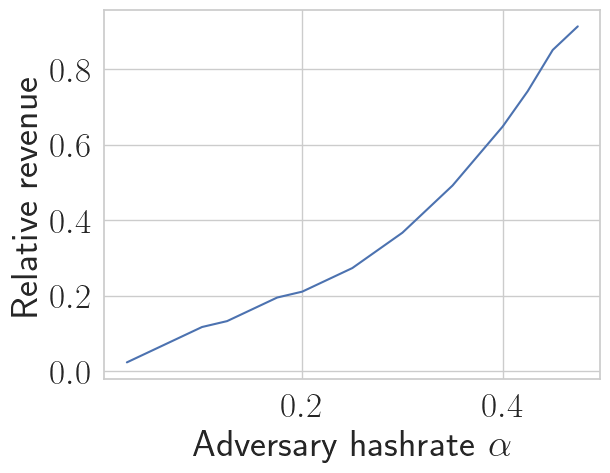

In [80]:
gamma = 0.5
stale = 0.1
cost = 0
relative_reward(stale, gamma, 20, cost, lam=0, eps=0.1)